In [1]:
from sympy import *
from sympy.abc import r,x,y,z
from sympy import init_printing
from cubature import cubature
import sympy.printing.llvmjitcode as jit
from timeit import timeit
import matplotlib.pyplot as plt
%matplotlib inline
init_printing()

# Energy of a Helium atom

he Hamiltonian for this system is
$$-\frac{1}{2} (\nabla_1^2 + \nabla_2^2) - \frac{2}{r_1} - \frac{2}{r_2} + \frac{1}{r_{12}}$$


In [2]:
r1 = Symbol('r1')    # magnitude of vector r1 (electron 1 to nucleus distance)
r2 = Symbol('r2')    # magnitude of vector r2 (electorn 2 to nucleus distance)
r12 = Symbol('r12') # |r2-r1| (magnitude of vector r2-r1)


### Simple trial wavefunction

In [3]:
beta = Symbol('beta')
R1 = exp(-2*r1)
R2 = exp(-2*r2)
G = exp(r12/2/(1 + beta*r12))
R1*R2*G

In [4]:
def del_spherical(e, r):
    """Compute Laplacian for expression e with respect to symbol r.
        Currently works only with radial dependence"""
    t1 = r*r*diff(e, r)
    t2 = diff(t1, r)/(r*r)
    return simplify(t2)

def grad_spherical(e, r, rhat):
    """Compute gradient for expresion e with respect to symbol r.
       The symbol rhat is the unit vector in the radial direction."""
    t1 = diff(e, r)
    t2 = simplify(t1)
    return t2*rhat



In [5]:
# Wavefunction has the form F1 * F2 * G
# grad (FG) = G grad(F) + F grad(G)

def grad_combo(F, gradF, G, gradG):
    t = F*gradG + G*gradF
    return simplify(t)

# del^2 (FG) = G del^2(F0 + F del^2(G) + 2 grad(F) * grad(G)
def del_combo(F, gradF, delsqF, G, gradG, delsqG):
    t = G * delsqF + F * delsqG + 2*gradF*gradG
    t2 = t.subs(rhat1*rhat1, 1)
    t3 = t2.subs(rhat2*rhat2, 1)
    t4 = t3.subs(rhat12*rhat12, 1)
    t5 = t4.subs(rhat1*rhat12, rhat1_12)
    t6 = t5.subs(rhat2*rhat12, rhat2_12)
    return simplify(t6)


In [14]:
# Unit vectors
rhat1 = Symbol('rhat1')
rhat2 = Symbol('rhat2')
rhat12 = Symbol('rhat12')
rhat1_12 = Symbol('rhat1_12')
rhat2_12 = Symbol('rhat2_12')

In [7]:
# TODO: Explain this derivation
grad_1 = grad_spherical(R1, r1, rhat1)
del2_1 = del_spherical(R1, r1)

grad_2 = grad_spherical(R2, r2, rhat2)
del2_2 = del_spherical(R2, r2)

gradG_1 = grad_spherical(G, r12, rhat12)
del2G_1 = del_spherical(G, r12)

grad_R1G = grad_combo(R1, grad_1, G, -gradG_1)

delsq_R1G = del_combo(R1, grad_1, del2_1, G, -gradG_1, del2G_1)


grad_R2G = grad_combo(R2, grad_2, G, gradG_1)
delsq_R2G = del_combo(R2, grad_2, del2_2, G, gradG_1, del2G_1)

psi2 = R1*R1*R2*R2*G*G
h1 = -1/2 * (R2*R2) * R1 * G * delsq_R1G - 2*psi2/r1
h2 = -1/2 * (R1*R1) * R2 * G * delsq_R2G - 2*psi2/r2
h = h1 + h2 + psi2/r12
h = simplify(h)

In [8]:
# Symbols for performing the integration
x1,y1,z1 = symbols('x1 y1 z1')
x2,y2,z2 = symbols('x2 y2 z2')
# Add a very tiny softening to keep the evaluation of the integrand from blowing up at certain points.
r1_c = sqrt(x1*x1 + y1*y1 + z1*z1 + 1e-20)
r2_c = sqrt(x2*x2 + y2*y2 + z2*z2 + 1e-20)
r12_c = sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1) + (z2-z1)*(z2-z1) + 1e-20)
rhat1_12_c = (x1*(x2-x1) + y1*(y2-y1) + z1*(z2-z1))/r1_c/r12_c
rhat2_12_c = (x2*(x2-x1) + y2*(y2-y1) + z2*(z2-z1))/r2_c/r12_c

In [15]:
# Set up replacements before integration
rep = {
    r1 : r1_c,
    r2 : r2_c,
    r12 : r12_c,
    rhat1_12 : rhat1_12_c,
    rhat2_12 : rhat2_12_c
}
tmp = h.subs(rep)

tmp2 = psi2.subs(rep)

beta_val = 1.0
num = tmp.subs(beta, beta_val)
denom = simplify(tmp2.subs(beta, beta_val))

In [10]:
ndim = 6
lim_min = [-30.0]*ndim
lim_max = [30.0]*ndim

cub_denom_func = jit.llvm_callable([x1, y1, z1, x2, y2, z2], denom, callback_type='cubature')
cub_num_func = jit.llvm_callable([x1, y1, z1, x2, y2, z2], num, callback_type='cubature')

def cubature_quad():
    epsrel = 1e-4
    denom_res = cubature(cub_denom_func, ndim=ndim, fdim=1, xmin=lim_min, xmax=lim_max, relerr=epsrel)
    num_res = cubature(cub_num_func, ndim=ndim, fdim=1, xmin=lim_min, xmax=lim_max, relerr=epsrel)
    print('E = ',num_res[0][0]/denom_res[0][0])

time = timeit(stmt=cubature_quad, number=1)
print('Integration time with cubature and JIT callback = %0.3f s'%time)

E =  -2.82611430463
Integration time with cubature and JIT callback = 194.862 s


In [11]:
# Use CSE (Common Subexpression Elimination) structure to replacements and to actually perform CSE.
repls = [(r1, r1_c), (r2, r2_c), (r12, r12_c), (rhat1_12, rhat1_12_c), (rhat2_12, rhat2_12_c)]
repls_n = [a for a in repls]
tmp_h = h.subs(beta, beta_val)
tmp_n = psi2.subs(beta, beta_val)

cse_h = cse(tmp_h)
repls.extend(cse_h[0])
expr_h = [repls, [cse_h[1][0]]]

cse_n = cse(tmp_n)
repls_n.extend(cse_n[0])
expr_n = [repls_n, [cse_n[1][0]]]

jit_expr_num = jit.llvm_callable( [x1, y1, z1, x2, y2, z2], expr_h, callback_type='cubature')
jit_expr_denom = jit.llvm_callable( [x1, y1, z1, x2, y2, z2], expr_n, callback_type='cubature')
          
def cse_cubature_quad():
    epsabs = 1e-4
    epsrel = 1e-4
    denom_res = cubature(jit_expr_denom, ndim=ndim, fdim=1, xmin=lim_min, xmax=lim_max, relerr=epsrel)
    num_res = cubature(jit_expr_num, ndim=ndim, fdim=1, xmin=lim_min, xmax=lim_max, relerr=epsrel)
    print('E = ',num_res[0][0]/denom_res[0][0])

time = timeit(stmt=cse_cubature_quad, number=1)
print('Integration time with CSE before cubature and JIT callback = %0.3f s'%time)

E =  -2.82611410497
Integration time with CSE before cubature and JIT callback = 139.659 s


In [16]:
# Collect computation of energy into a single function
def compute_energy(beta_val):
    repls = [(r1, r1_c), (r2, r2_c), (r12, r12_c), (rhat1_12, rhat1_12_c), (rhat2_12, rhat2_12_c)]
    repls_n = [a for a in repls]
    tmp_h = h.subs(beta, beta_val)
    tmp_n = psi2.subs(beta, beta_val)

    cse_h = cse(tmp_h)
    repls.extend(cse_h[0])
    expr_h = [repls, [cse_h[1][0]]]

    cse_n = cse(tmp_n)
    repls_n.extend(cse_n[0])
    expr_n = [repls_n, [cse_n[1][0]]]

    jit_expr_num = jit.llvm_callable( [x1, y1, z1, x2, y2, z2], expr_h, callback_type='cubature')
    jit_expr_denom = jit.llvm_callable( [x1, y1, z1, x2, y2, z2], expr_n, callback_type='cubature')

    epsrel = 1e-4
    denom_res = cubature(jit_expr_denom, ndim=ndim, fdim=1, xmin=lim_min, xmax=lim_max, relerr=epsrel)
    num_res = cubature(jit_expr_num, ndim=ndim, fdim=1, xmin=lim_min, xmax=lim_max, relerr=epsrel)
    E = num_res[0][0]/denom_res[0][0]
    return E


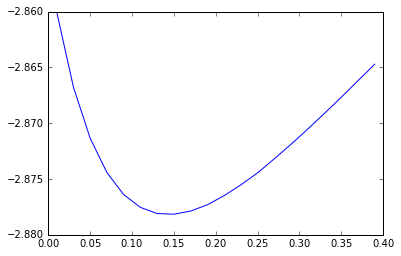

In [13]:
energies = []
betas = []
for i in range(20):
    beta_val = i*.02 + 0.01
    e = compute_energy(beta_val)
    #print(beta_val, e)
    betas.append(beta_val)
    energies.append(e)

plt.plot(betas, energies)